# Stock Prediction

This project introduces common techniques to manipulate time series and make predictions.

The data is a sample from the historical [US stock prices in the last 5 years](https://intrinio.com/bulk-financial-data-downloads/all). Only the New German Fund (GF) will be considered for analysis. 

There roughly 1000 days of recoreded trading for GF.

## Clean data 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('Solarize_Light2')
sns.set_context(
    "notebook",
    rc={
        "figure.figsize": (17, 8),
        "axes.titlesize": 18
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 17, 8

DATAPATH = 'data/stock_prices_sample.csv'

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

data = pd.read_csv(DATAPATH, index_col=['DATE'], parse_dates=['DATE'])
data.head(10)

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.2300,47.3700,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.1400,46.4800,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.1600,46.4100,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.8700,18.8700,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.7900,18.8100,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0
2018-06-01,GF,BBG000C3C6S2,EOD,daily,18.58,18.7600,18.5800,18.7400,17468.0,18.580000,18.760000,18.580000,18.740000,17468.0,NaN,0.0,1.0
2018-05-31,GF,BBG000C3C6S2,EOD,daily,18.52,18.5200,18.3012,18.4900,22384.0,18.520000,18.520000,18.301200,18.490000,22384.0,NaN,0.0,1.0
2018-05-30,GF,BBG000C3C6S2,EOD,daily,18.47,18.6780,18.4700,18.6500,22633.0,18.470000,18.678000,18.470000,18.650000,22633.0,NaN,0.0,1.0
2018-05-29,GF,BBG000C3C6S2,EOD,daily,18.51,18.5100,18.1500,18.2562,67412.0,18.510000,18.510000,18.150000,18.256200,67412.0,NaN,0.0,1.0


In [2]:
data = data[data.TICKER == 'GF']
data = data[data.TYPE == 'EOD']

drop_cols = ['SPLIT_RATIO', 'EX_DIVIDEND', 'ADJ_FACTOR', 'ADJ_VOLUME', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH', 'ADJ_OPEN', 'VOLUME', 'FREQUENCY', 'TYPE', 'FIGI']

data.drop(drop_cols, axis=1, inplace=True)

data.head()

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100
2018-06-01,GF,18.58,18.760,18.5800,18.7400
2018-05-31,GF,18.52,18.520,18.3012,18.4900
2018-05-30,GF,18.47,18.678,18.4700,18.6500
2018-05-29,GF,18.51,18.510,18.1500,18.2562


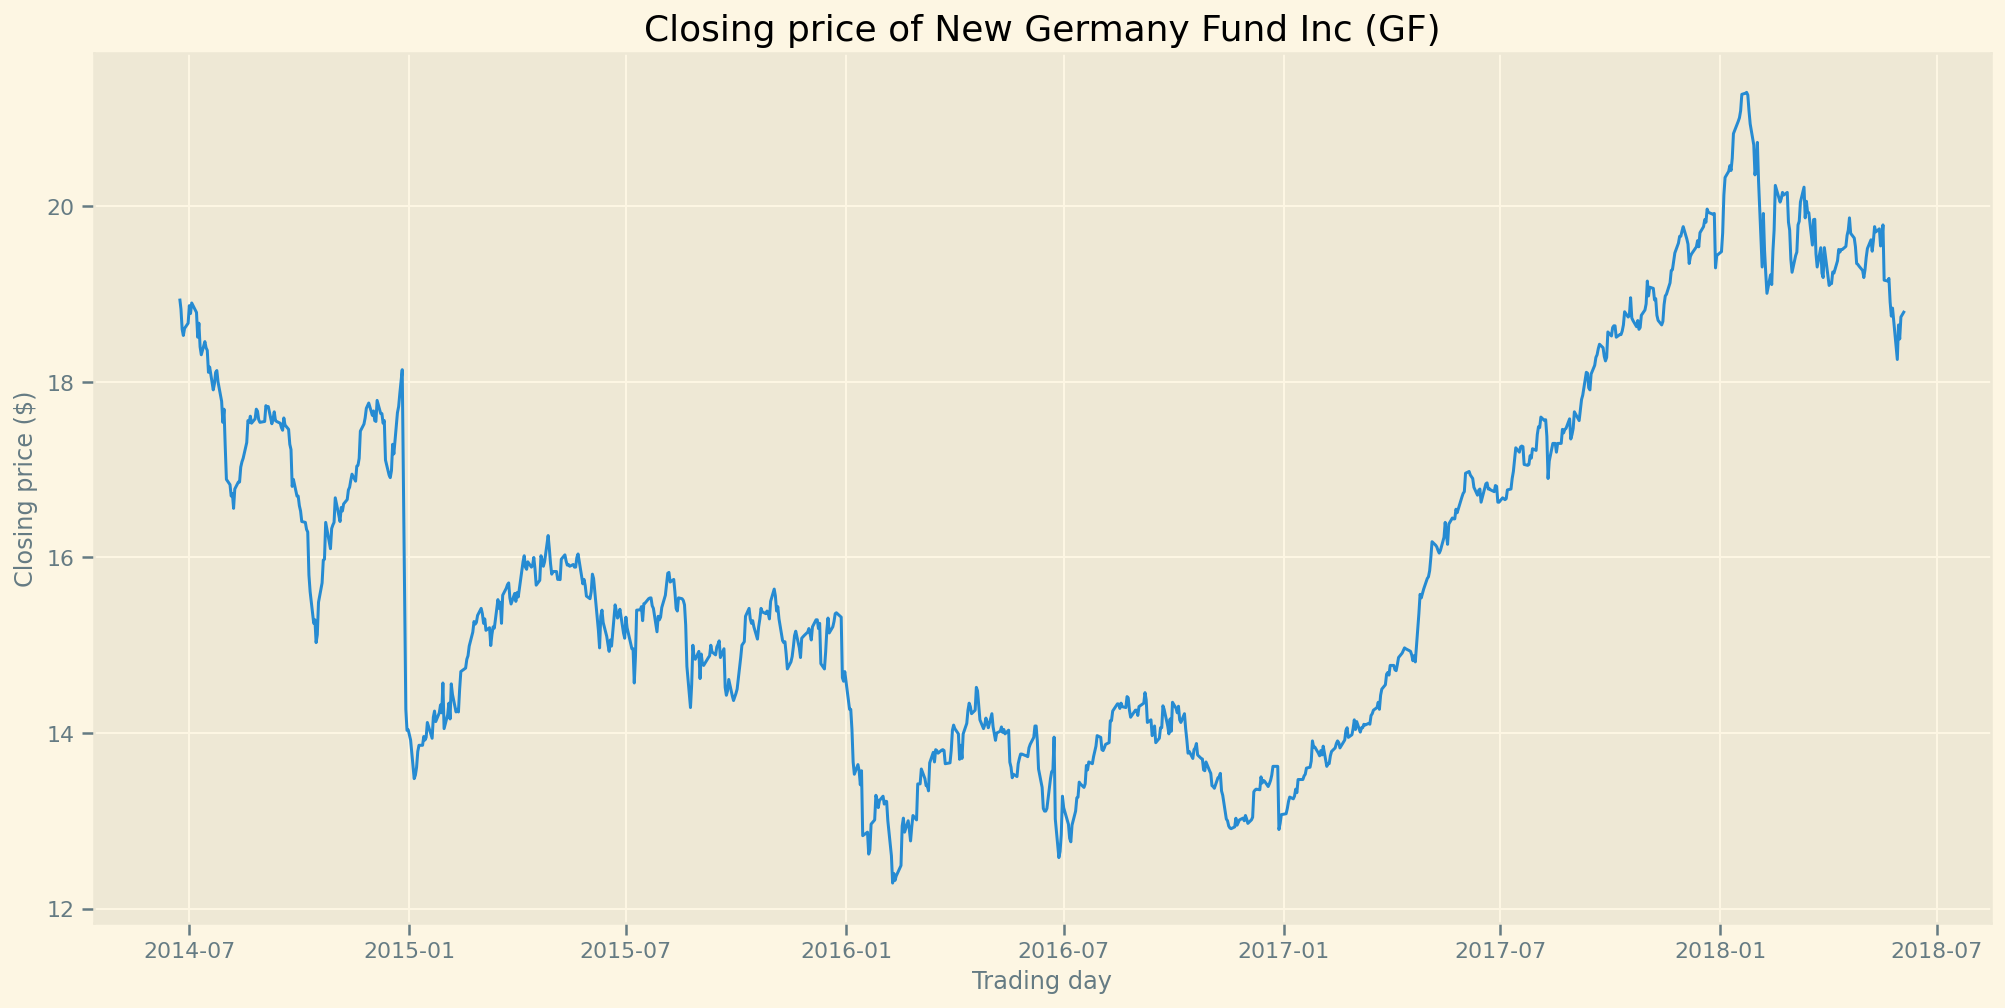

In [3]:
plt.plot(data.CLOSE)
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(True)
plt.show()

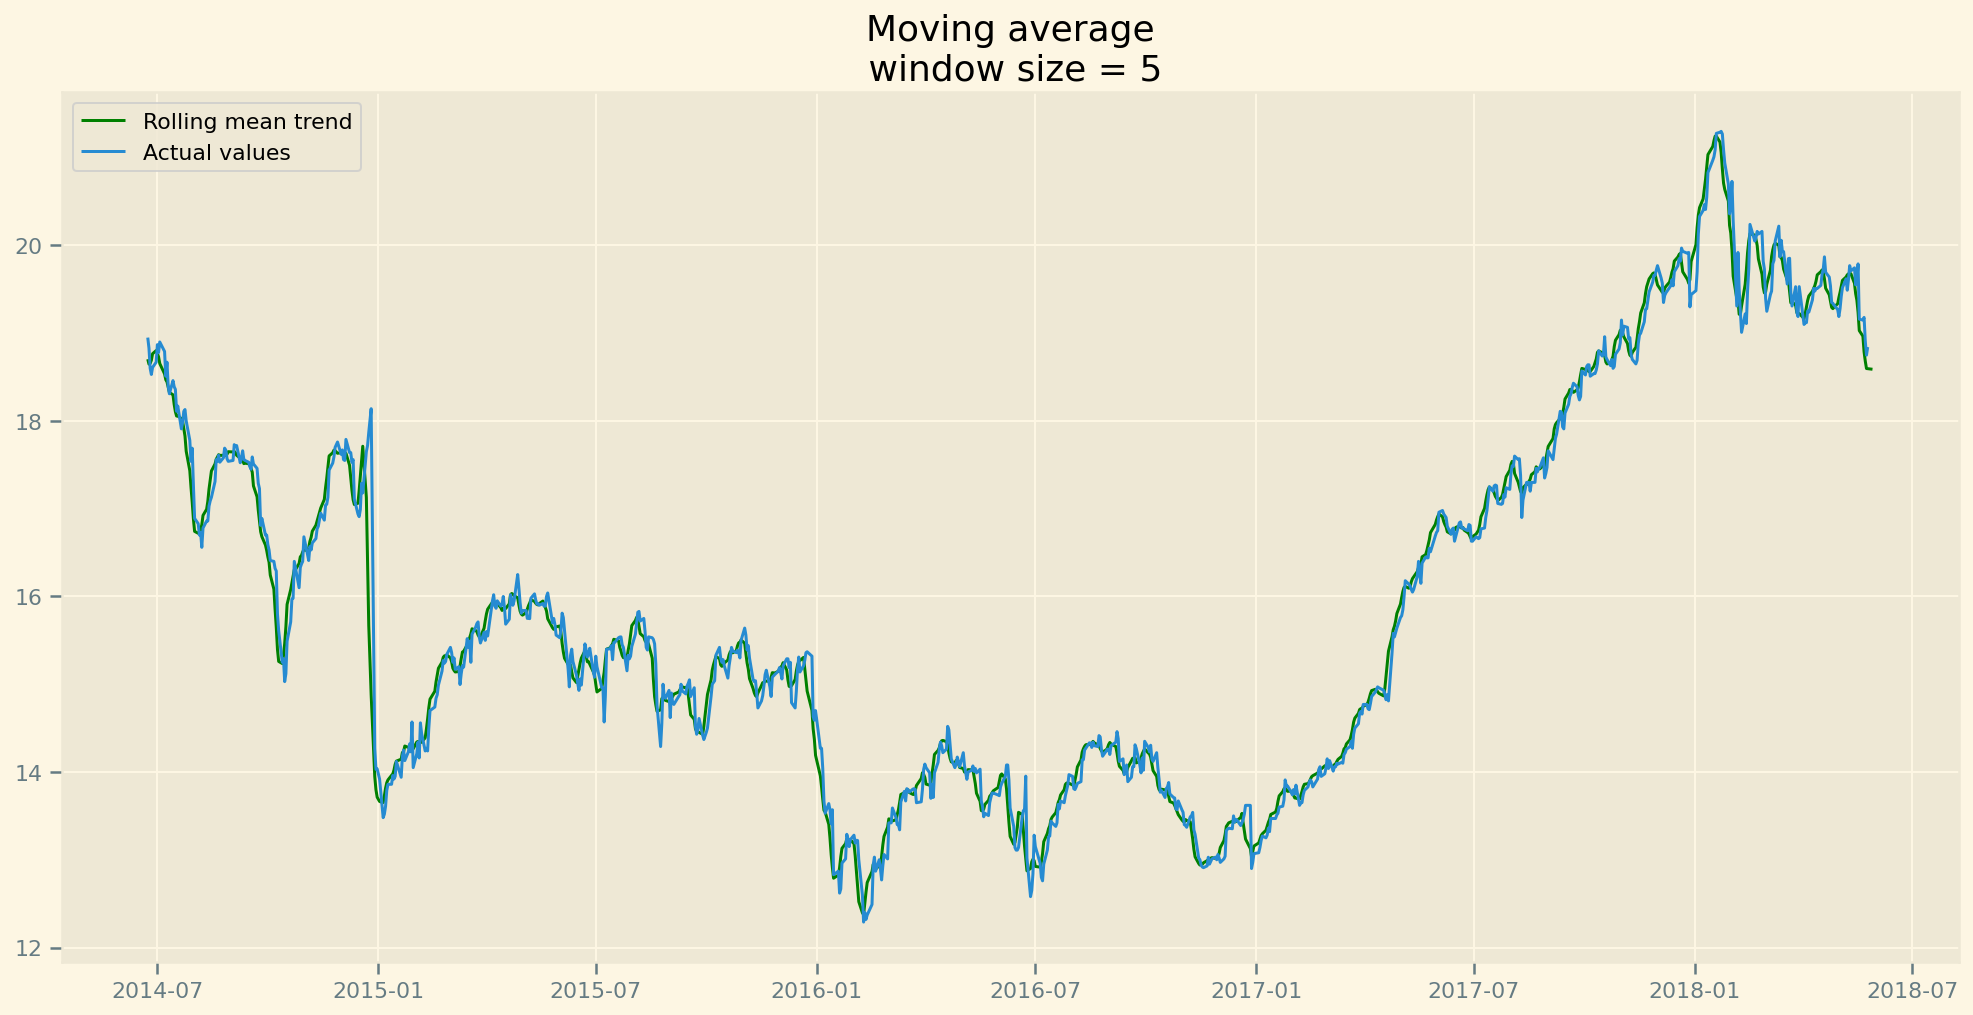

In [4]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()

    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

plot_moving_average(data.CLOSE, 5)

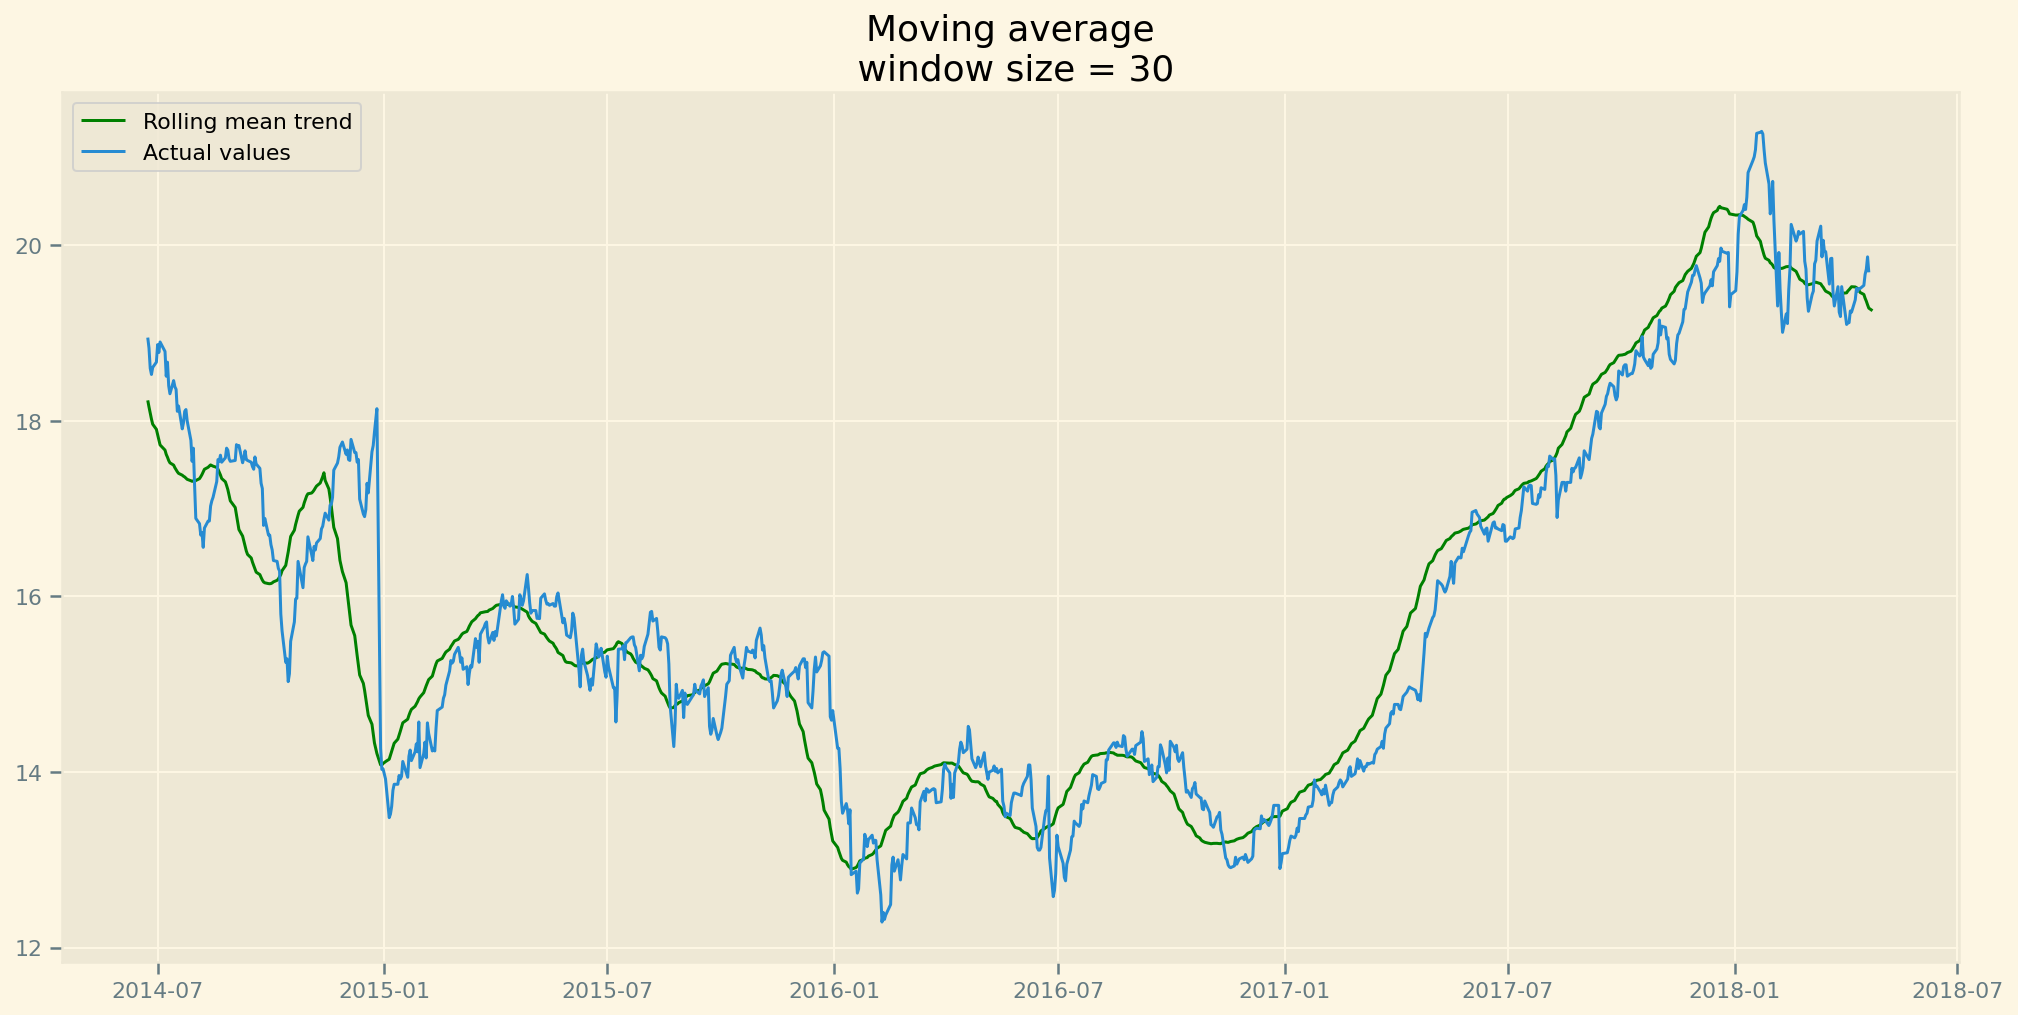

In [5]:
plot_moving_average(data.CLOSE, 30)

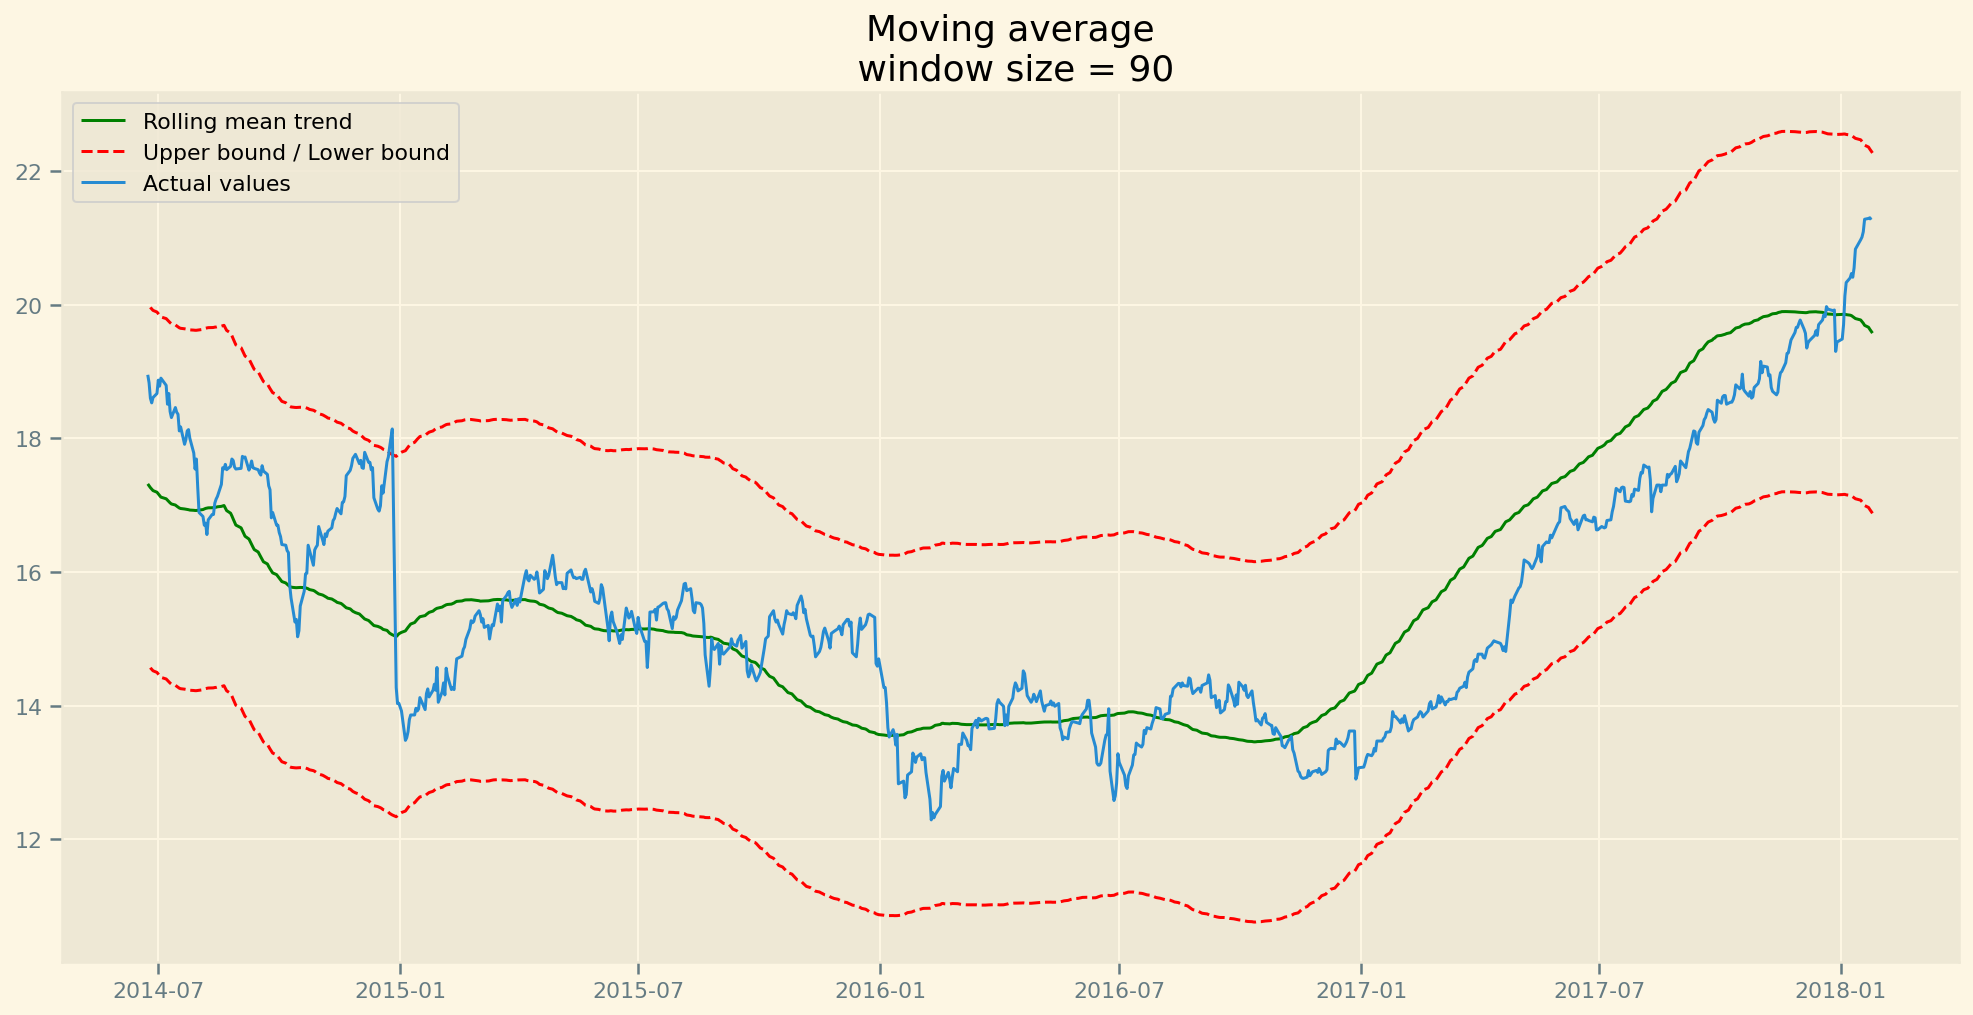

In [6]:
plot_moving_average(data.CLOSE, 90, plot_intervals=True)

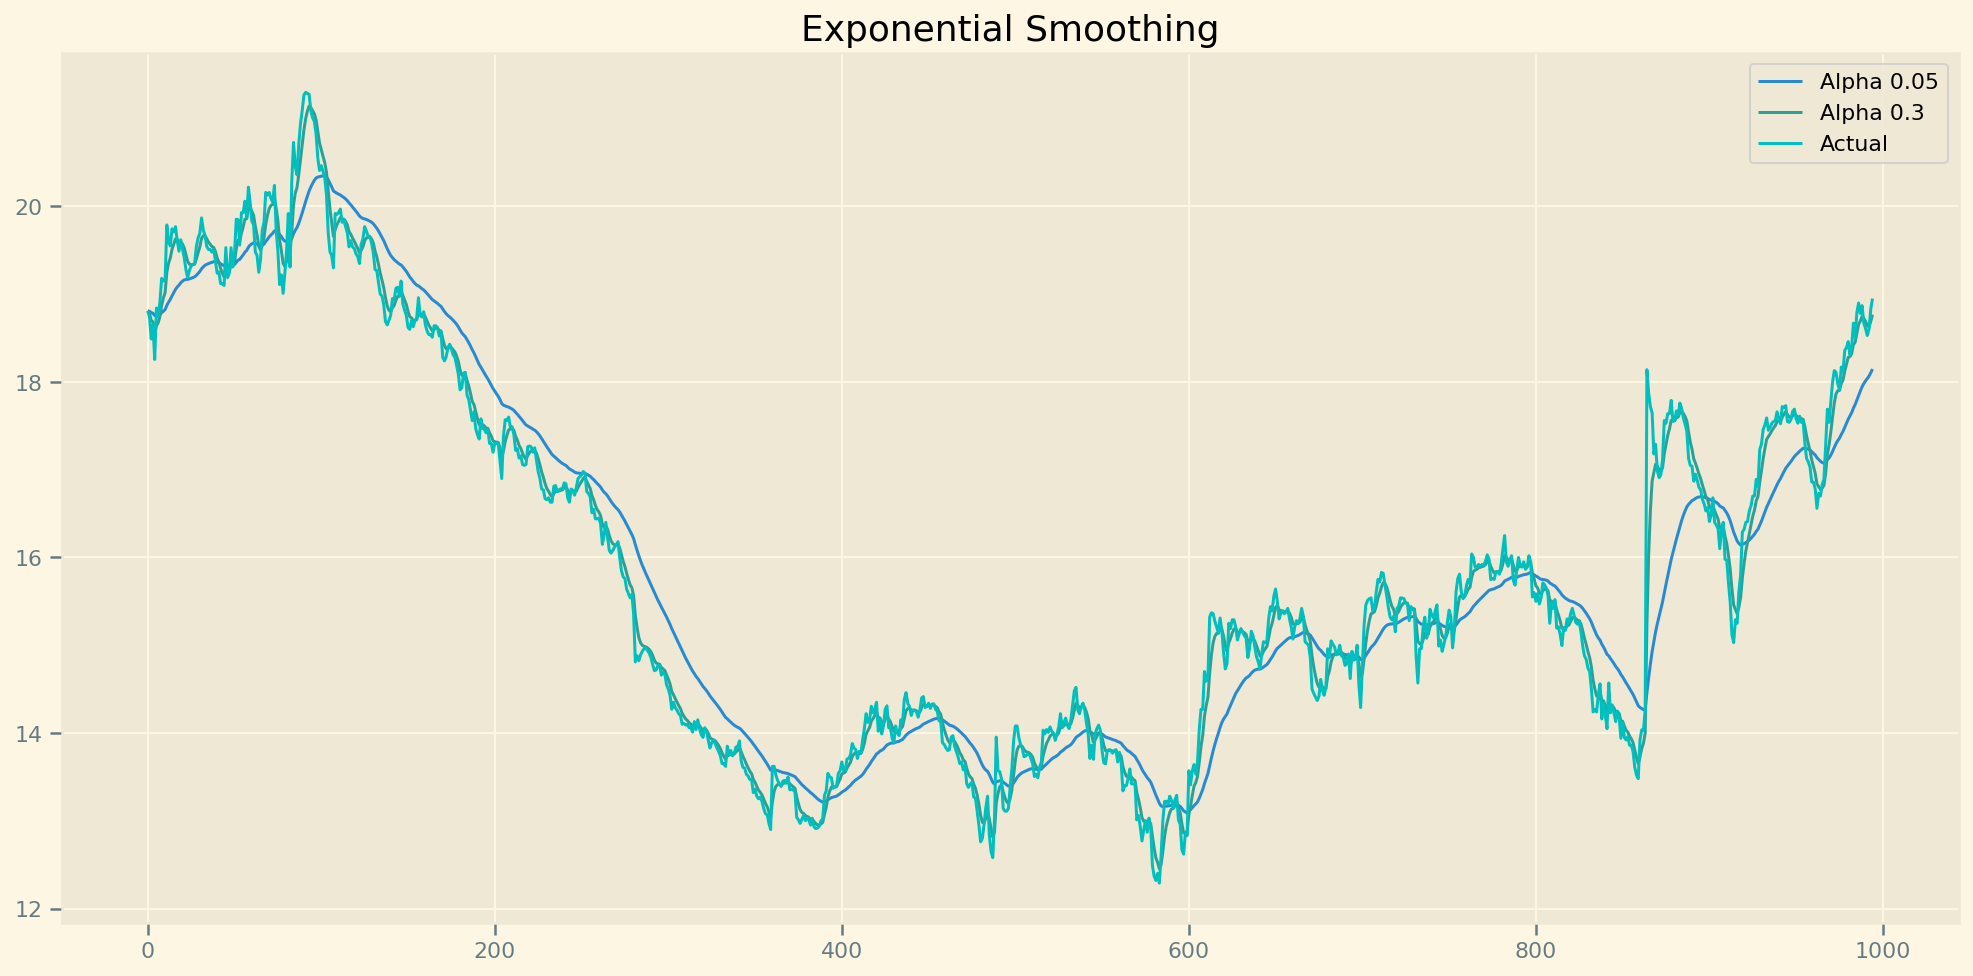

In [7]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data.CLOSE, [0.05, 0.3])

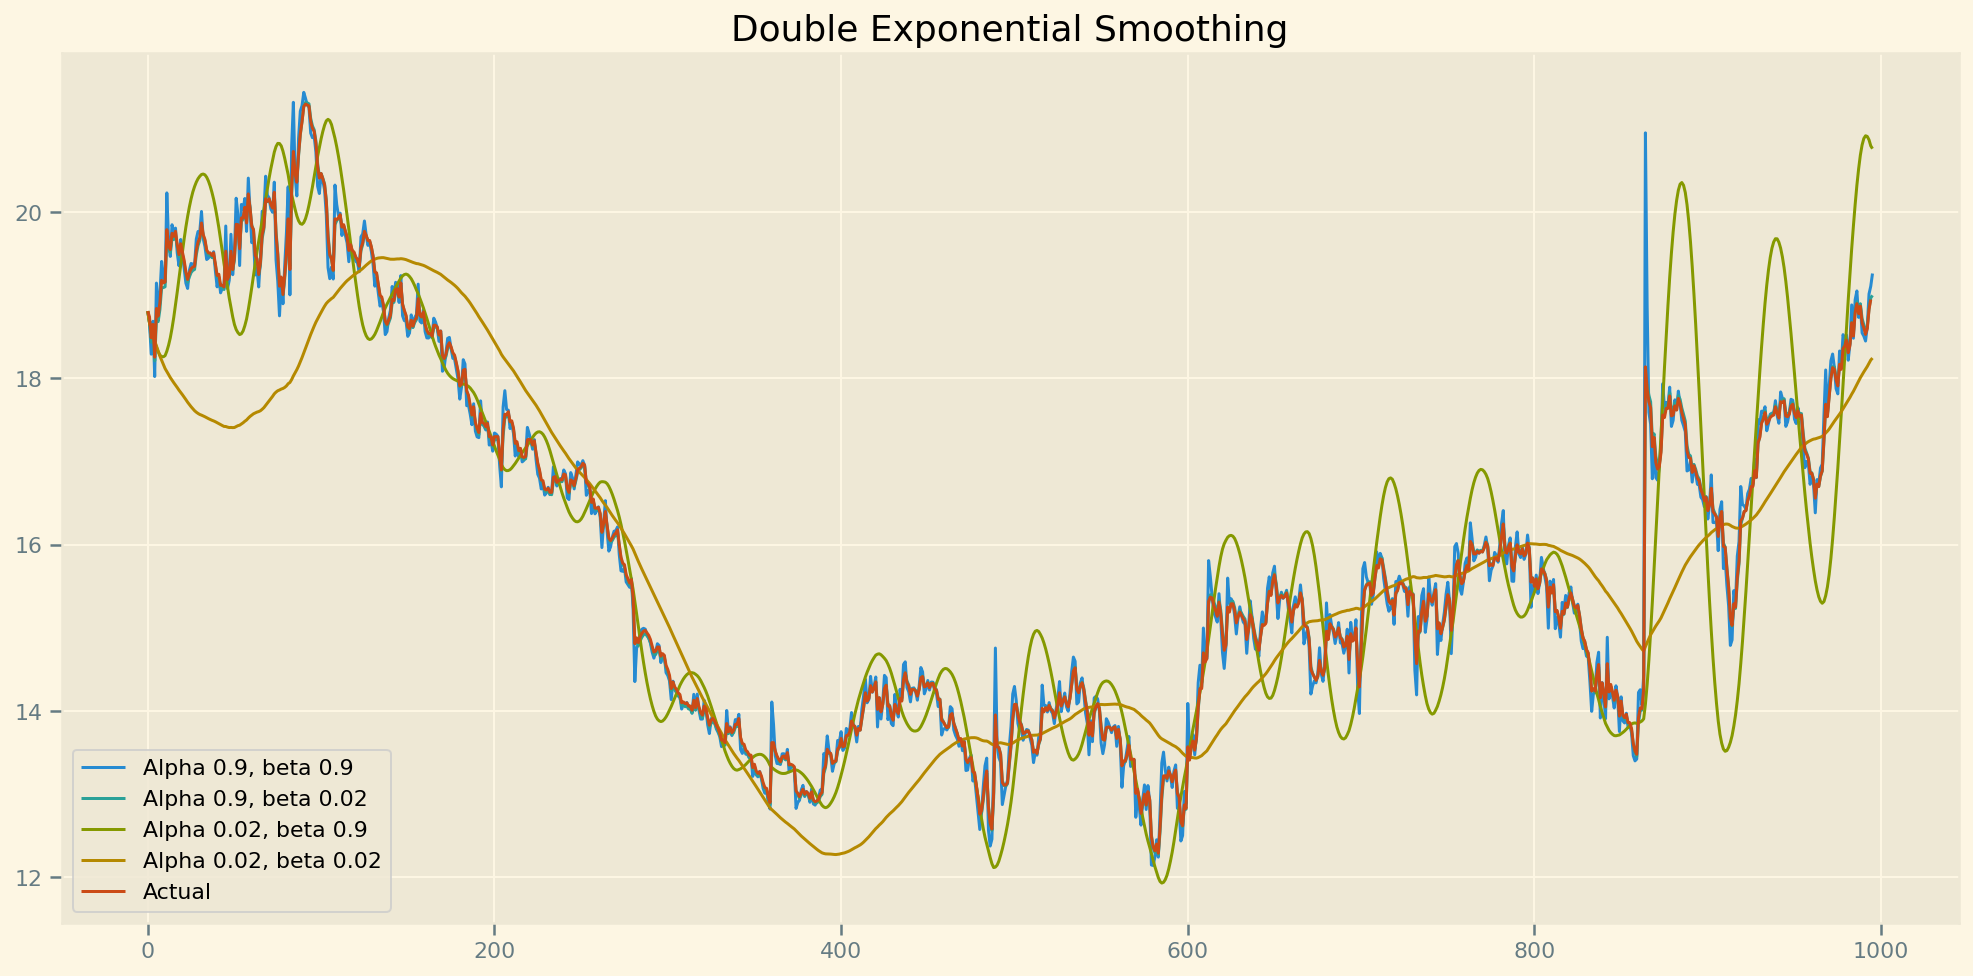

In [8]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(data.CLOSE, alphas=[0.9, 0.02], betas=[0.9, 0.02])

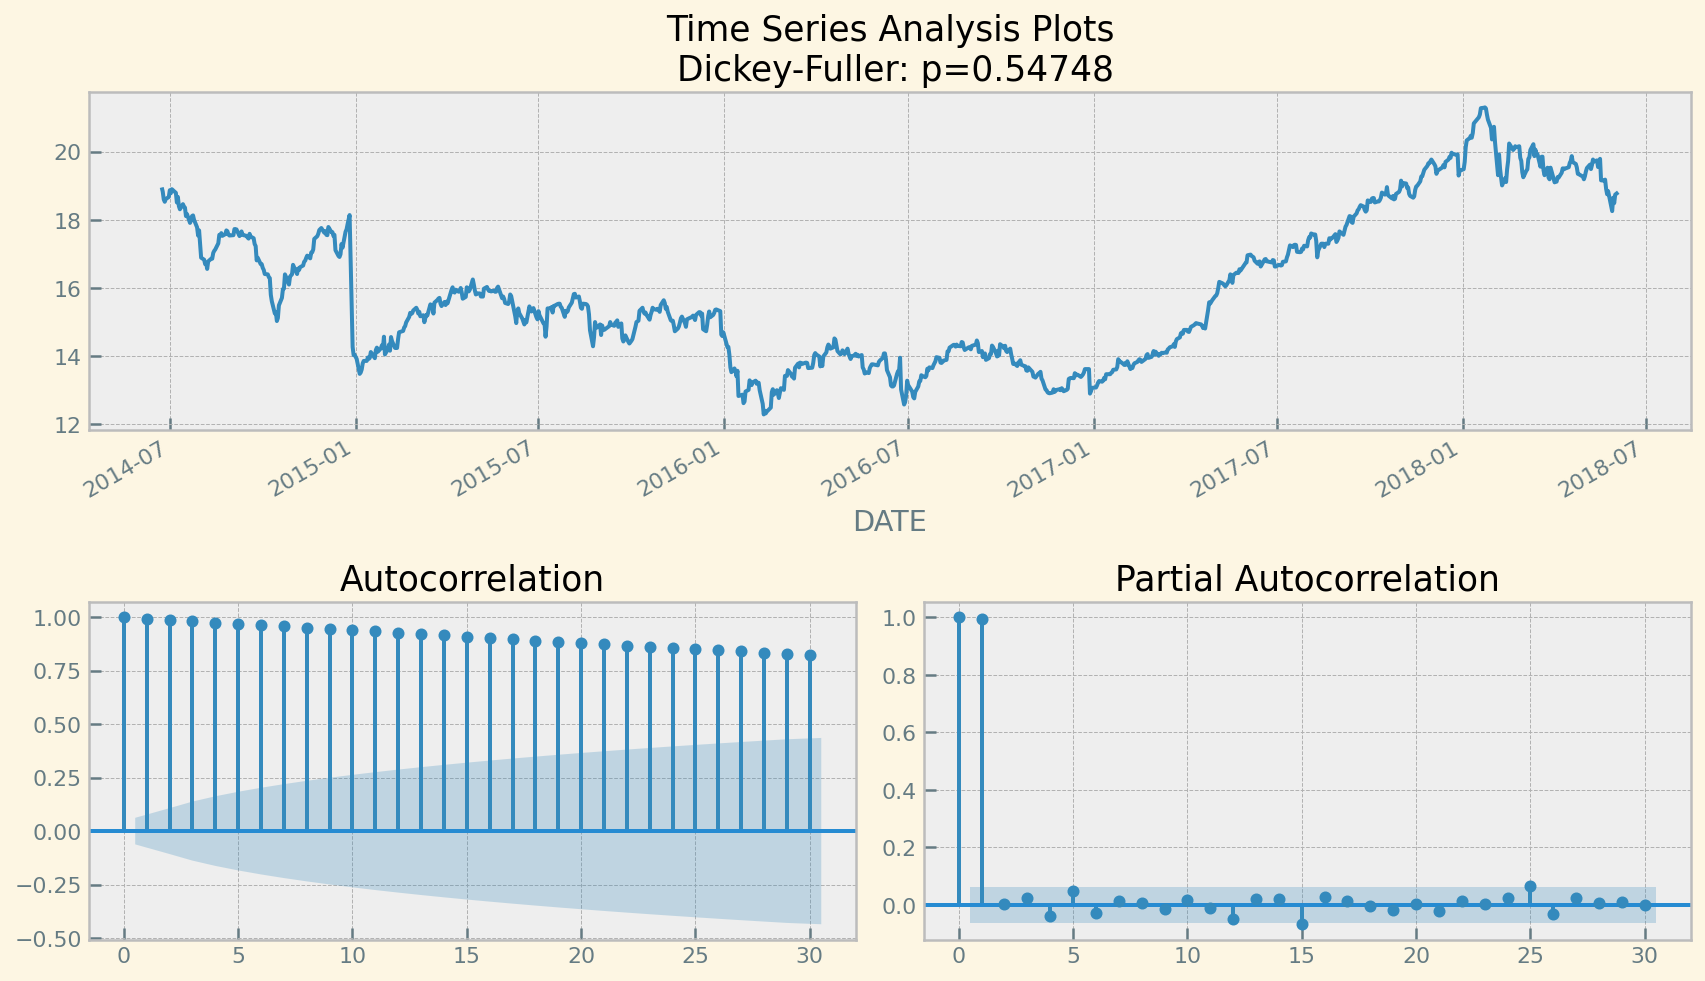

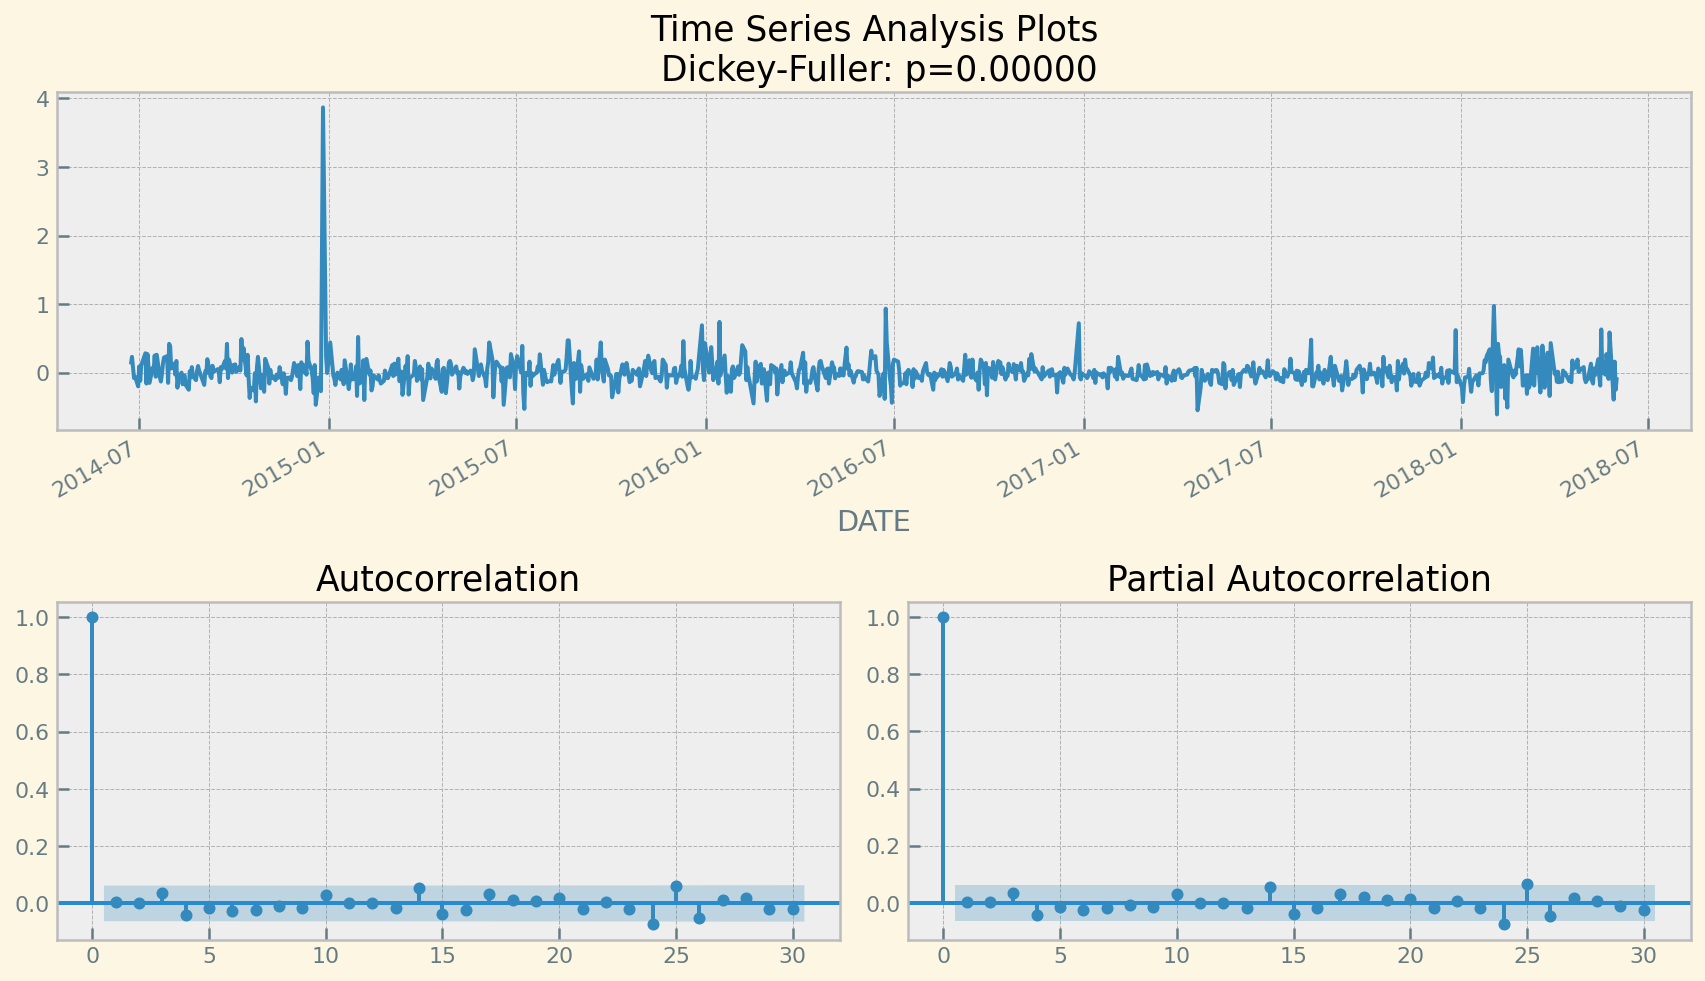

In [9]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(data.CLOSE, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data.CLOSE - data.CLOSE.shift(1)

tsplot(data_diff[1:], lags=30)

In [10]:
# Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

# Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
# noinspection PyPep8Naming
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float('inf')

    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic

        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

  0%|          | 0/625 [00:00<?, ?it/s]

                                          SARIMAX Results                                           
Dep. Variable:                                        CLOSE   No. Observations:                  995
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2, 3, 4], 5)   Log Likelihood                 148.875
Date:                                      Tue, 16 Feb 2021   AIC                           -283.751
Time:                                              11:07:29   BIC                           -249.474
Sample:                                                   0   HQIC                          -270.716
                                                      - 995                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.4947      0.162  